# Lesson 5: the trouble with slope area

*This lesson has been written by Simon M. Mudd at the University of Edinburgh*

*Last update 30/09/2021*

In the past few lessons, we have learned:
    
* Channels tend to have a higher gradient near their headwaters (i.e., parts of the network with low drainage area).
* If the landscape is on uniform bedrock, and has an uplift rate that has remained steady for a long time, the relationship between slope and area looks like $S = k_s A^{-\theta}$. 
* If the landscape is perturbed in some way, channel steepness will diverge from this idealised shape. 
* We might look for parts of the channel experiencing some sort of perturbation (i.e., changing lithology, changing uplift in space and time) by looking for parts of the landscape that are steeper than others. 
* Channel gradient doesn't work since it is changing along the channel even if there are no perturbations. So instead we look for changes in the "channel steepness index", or $k_s$ from the equation above. Areas of elevated $k_s$ are also known as knickpoints.


## Using real data

Okay, so lets try to fit some real data, and look for changes to the channel steepness. I prepared some data previously, which we will look at using `geopandas`.

In [1]:
import pandas as pd
import geopandas as gpd

First read a csv that I made from Xi'an (see lesson_01) that contains slope and area data:

In [2]:
df = pd.read_csv("Xian_SAvertical.csv")

Just to show you what is in this file, I will print out the data elements:

In [3]:
df.head()

,latitude,longitude,chi,elevation,flow_distance,drainage_area,slope,source_key,basin_key
0,34.416561,110.287985,3.3432,1078.0,17788.0,4855500.0,0.063859,0,0
1,34.416561,110.287985,3.3432,1078.0,17788.0,4855500.0,0.069940,0,0
2,34.416561,110.287985,3.3432,1078.0,17788.0,4855500.0,0.060948,0,0
3,34.417378,110.288957,3.2782,1073.0,17643.0,5007600.0,0.058736,0,0
4,34.418189,110.288950,3.2270,1067.0,17528.0,5049900.0,0.056067,0,0


Each point has a latitude and longitude. Meaning it is spatial data. So we can load it as a `geopandas` dataframe: that is a kind of python object for holding geographic data. I wrote this data so I happen to know its coordinate system. It is in the global WGS84 geographic coordinate system. All coordinate systems have an EPSG code. This system's code is `epsg=4326`. I set that system after loading the data.

**A slight note on coordinate systems**: coordinate systems might seem an arcane topic but if you are doing something in a GIS or manipulating spatial data and something goes wrong, a messed up coordinate system is frequently to blame. If I had to guess, i would say betwen 1/3-1/2 of problems students bring to me are solved by fixing the coordinate system. A very brief overview can be found here: https://lsdtopotools.github.io/LSDTT_documentation/LSDTT_introduction_to_geospatial_data.html#_projections_and_transformations

Okay, now that I have said that, lets go on to importing some data

In [4]:
# This changes a pandas dataframe (reminder, pandas is a little bit like the excel of python)
# to a geopandas dataframe (which means the data has spatial information)
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf = gdf.set_crs(epsg=4326)
gdf.head()

,latitude,longitude,chi,elevation,flow_distance,drainage_area,slope,source_key,basin_key,geometry
0,34.416561,110.287985,3.3432,1078.0,17788.0,4855500.0,0.063859,0,0,POINT (110.28799 34.41656)
1,34.416561,110.287985,3.3432,1078.0,17788.0,4855500.0,0.069940,0,0,POINT (110.28799 34.41656)
2,34.416561,110.287985,3.3432,1078.0,17788.0,4855500.0,0.060948,0,0,POINT (110.28799 34.41656)
3,34.417378,110.288957,3.2782,1073.0,17643.0,5007600.0,0.058736,0,0,POINT (110.28896 34.41738)
4,34.418189,110.288950,3.2270,1067.0,17528.0,5049900.0,0.056067,0,0,POINT (110.28895 34.41819)


Just to see where these are, we can use some map tiles. Here comes another EPSG code! This time we conver to something called web mercator, which all of the map tiling services (e.g., google maps) use. It is `epsg:3857`. But first we need to know the bounds of the data. 

In [5]:
bounds = gdf.total_bounds
print(bounds)

[109.358017   34.1210761 110.975498   34.524376 ]


Now we are going to plot these data, to show you where they are. 
They are in a few basins near Xian, China.

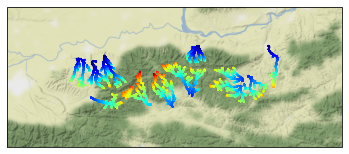

In [6]:
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

stamen_terrain = cimgt.Stamen('terrain-background')

fig = plt.figure()

# Create a GeoAxes in the tile's projection.
ax = fig.add_subplot(1, 1, 1, projection=stamen_terrain.crs)

# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent([bounds[0]-0.5, bounds[2]+0.5, bounds[1]-0.25, bounds[3]+0.25], crs=ccrs.Geodetic())

# Add the Stamen data at zoom level 8.
ax.add_image(stamen_terrain, 8)

# Add the channel data
gdf = gdf.to_crs(epsg=3857)    # We have to convert the data to the same 
                               #system as the ap tiles. It happens to be this one. 
                               # This epsg code is used for all map tiles (like google maps)
gdf.plot(ax=ax, markersize=0.5, column='chi', zorder=10,cmap="jet")


Now lets plot the slope area data:

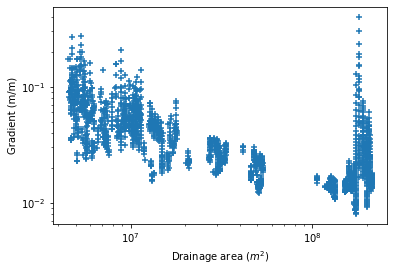

In [7]:
# First lets isolate just one of these basins. They go from 0 to 12
gdf_b1 = gdf[(gdf['basin_key'] == 12)]

# Now make the slope area plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.scatter(gdf_b1.drainage_area,gdf_b1.slope,marker="+")
plt.xlabel(r"Drainage area ($m^2$)")
plt.ylabel("Gradient (m/m)")
ax.set_xscale('log')
ax.set_yscale('log')
fig.show()

__Task:__ Change the basin number. How noisy are the slope area plots?

**What is happening?**

Well, first of all, the gaps in drainage area are because there are tributary junctions where the drainage area takes a step change. Then,  between junctions, drainage are doesn't change much, but channels are rough: you get some boulders making some steps, or a little bit of slack water behind a log, etc. These mean that local gradient can change a lot between tributary junctions. So this shows up as a bunch of different gradients at apparently the same drainage area. 

These factors combine to make this a very noisy plot. When you see papers with slope-area data, it has been through some smoothing and binning routine, so you tend not to see figures this messy in scientific paper. But I assure you **all** slope area data is this messy before you start to bin and smooth it. 

In the next lesson we will explore a way to make these data less noisy. 